# **Title**

## **Overview**

## **Data Description**

## **Initial Assumptions and Predictions About the Data**

## **Exploratory Data Analysis**

### **Data Cleaning**

In [394]:
# importing the relevant libraries

# cleaning libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from thefuzz import process
import pycountry_convert as pc

# visualization libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from tabulate import tabulate

# for clustering
from sklearn.cluster import KMeans
# for hypothesis test

In [235]:
# loading in the datasets

# defining names of csv files with similar structures
data_names = ['inflation', 'gdp', 'gdp_growth', 'exports', 'imports',
              'current_account', 'population', 'unemployment', 'fdi']

# for loop to assign variables for each file and creating copy
for name in data_names:
    globals()[name] = pd.read_csv(f"{name}.csv", skiprows=4) 
    globals()[f"{name}_og"] = globals()[name].copy()

# loading hdi file and making copy
hdi = pd.read_csv("hdi.csv")
hdi_og = hdi.copy()

# loading covid file and making copy
covid = pd.read_csv("covid.csv")
covid_og = covid.copy()

### **a) Economic Performance Indicators**

In [238]:
for name in data_names:
    indicator = globals()[name]  # Get the DataFrame by its variable name

    # Step 1: Remove the last column
    indicator = indicator.iloc[:, :-1]

    # Step 2: Calculate the mean from 2010-2019
    mean_pre_covid = indicator.iloc[:, -14:-4].mean(axis=1)

    # Step 3: Calculate the mean from 2020-2023 and drop rows with >2 nulls in those columns
    post_covid = indicator.iloc[:, -4:]
    mean_post_covid = post_covid.mean(axis=1)
    indicator = indicator[post_covid.isnull().sum(axis=1) <= 2]

    # Optionally, store the computed means in the DataFrame
    indicator[f"{name}_pre_covid"] = mean_pre_covid
    indicator[f"{name}_post_covid"] = mean_post_covid

    # Save back the modified DataFrame
    globals()[name] = indicator

In [239]:
econ_indicators = globals()[data_names[0]][["Country Code", "Country Name", data_names[0] + "_pre_covid", data_names[0] + "_post_covid"]]

for name in data_names[1:]:
    indicator = globals()[name][["Country Code", name + "_pre_covid", name + "_post_covid"]]
    
    # Merge on "Country Code"
    econ_indicators = pd.merge(econ_indicators, indicator, on="Country Code", how="inner")  # Use 'inner' to keep only common countries

econ_indicators

,Country Code,Country Name,inflation_pre_covid,inflation_post_covid,gdp_pre_covid,gdp_post_covid,gdp_growth_pre_covid,gdp_growth_post_covid,exports_pre_covid,exports_post_covid,imports_pre_covid,imports_post_covid,current_account_pre_covid,current_account_post_covid,population_pre_covid,population_post_covid,unemployment_pre_covid,unemployment_post_covid,fdi_pre_covid,fdi_post_covid
0,AGO,Angola,16.09,20.76,9.59e+10,7.61e+10,2.24,-0.10,44.21,42.83,31.27,26.46,3.34,7.66,2.77e+07,3.51e+07,16.56,15.41,-2.36,-4.80
1,ALB,Albania,2.12,3.79,1.30e+10,1.90e+10,2.59,3.60,29.32,32.38,46.83,43.19,-9.27,-5.82,2.89e+06,2.79e+06,14.49,10.85,8.41,7.06
2,ARM,Armenia,3.44,4.75,1.11e+10,1.75e+10,4.47,4.88,30.92,43.84,47.77,48.73,-6.83,-2.36,3.00e+06,2.97e+06,18.08,15.07,3.34,2.63
3,AUS,Australia,2.12,3.98,1.38e+12,1.58e+12,2.60,2.42,21.04,24.60,21.36,20.40,-3.02,1.64,2.37e+07,2.60e+07,5.51,4.74,3.70,2.36
4,AUT,Austria,1.86,5.13,4.17e+11,4.75e+11,1.58,0.70,53.99,57.26,50.76,55.78,1.88,1.39,8.61e+06,9.01e+06,5.24,5.48,-1.36,1.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,VUT,Vanuatu,1.87,4.78,7.96e+08,1.00e+09,2.65,-0.60,48.32,13.46,55.97,51.73,-4.52,-8.92,263926.60,309545.25,5.12,4.76,5.90,2.62
141,WSM,Samoa,1.72,4.18,8.14e+08,8.71e+08,2.41,-1.73,29.06,20.48,49.68,53.03,-3.31,-6.73,201059.70,214411.75,8.14,6.02,1.57,0.60
142,ZAF,South Africa,5.17,5.23,3.94e+11,3.87e+11,1.75,0.35,27.59,31.20,27.76,27.99,-3.31,0.91,5.59e+07,6.19e+07,25.76,32.15,1.08,3.44
143,ZMB,Zambia,8.75,14.91,2.42e+10,2.42e+10,4.89,3.51,37.69,44.99,36.20,33.24,0.50,6.33,1.62e+07,1.99e+07,7.17,5.78,5.19,0.81


### **b) Quality of Life Indicators**

In [243]:
set(econ_indicators["Country Code"]) - set(hdi["ISO3"])

{'MAC'}

In [245]:
def indic_mean_calculate(data, indicator):
    columns = [col for col in data.columns if col.startswith(indicator)]
    columns = [col for col in columns if int(col.split("(")[-1][:-1]) <= 2019]  # Only keep years ≤ 2019
    data[f"{indicator} (Mean)"] = data[columns].mean(axis=1)

# Define the indicators
indicators = [
    "Human Development Index",
    "Life Expectancy at Birth",
    "Expected Years of Schooling"
]

# Calculate mean for each indicator
for indicator in indicators:
    indic_mean_calculate(hdi, indicator)

hdi[["ISO3", "Human Development Index (Mean)", "Life Expectancy at Birth (Mean)", "Expected Years of Schooling (Mean)"]]

,ISO3,Human Development Index (Mean),Life Expectancy at Birth (Mean),Expected Years of Schooling (Mean)
0,AFG,0.39,57.16,6.97
1,AGO,0.50,51.71,7.03
2,ALB,0.71,76.52,12.18
3,AND,0.85,81.80,11.62
4,ARE,0.82,76.30,12.27
...,...,...,...,...
190,WSM,0.70,71.10,12.14
191,YEM,0.46,63.95,8.24
192,ZAF,0.67,60.17,13.19
193,ZMB,0.48,52.07,9.55


In [247]:
hdi_indicators = hdi[["ISO3", "Human Development Index (Mean)", "Life Expectancy at Birth (Mean)", "Expected Years of Schooling (Mean)"]]
econ_indicators = pd.merge(econ_indicators, hdi_indicators, 
                     left_on="Country Code", right_on="ISO3", 
                     how="inner").drop(columns=["ISO3"])

In [249]:
econ_indicators

,Country Code,Country Name,inflation_pre_covid,inflation_post_covid,gdp_pre_covid,gdp_post_covid,gdp_growth_pre_covid,gdp_growth_post_covid,exports_pre_covid,exports_post_covid,...,current_account_post_covid,population_pre_covid,population_post_covid,unemployment_pre_covid,unemployment_post_covid,fdi_pre_covid,fdi_post_covid,Human Development Index (Mean),Life Expectancy at Birth (Mean),Expected Years of Schooling (Mean)
0,AGO,Angola,16.09,20.76,9.59e+10,7.61e+10,2.24,-0.10,44.21,42.83,...,7.66,2.77e+07,3.51e+07,16.56,15.41,-2.36,-4.80,0.50,51.71,7.03
1,ALB,Albania,2.12,3.79,1.30e+10,1.90e+10,2.59,3.60,29.32,32.38,...,-5.82,2.89e+06,2.79e+06,14.49,10.85,8.41,7.06,0.71,76.52,12.18
2,ARM,Armenia,3.44,4.75,1.11e+10,1.75e+10,4.47,4.88,30.92,43.84,...,-2.36,3.00e+06,2.97e+06,18.08,15.07,3.34,2.63,0.70,71.67,11.94
3,AUS,Australia,2.12,3.98,1.38e+12,1.58e+12,2.60,2.42,21.04,24.60,...,1.64,2.37e+07,2.60e+07,5.51,4.74,3.70,2.36,0.91,80.53,20.83
4,AUT,Austria,1.86,5.13,4.17e+11,4.75e+11,1.58,0.70,53.99,57.26,...,1.39,8.61e+06,9.01e+06,5.24,5.48,-1.36,1.20,0.88,79.06,15.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,VUT,Vanuatu,1.87,4.78,7.96e+08,1.00e+09,2.65,-0.60,48.32,13.46,...,-8.92,263926.60,309545.25,5.12,4.76,5.90,2.62,0.59,69.13,10.86
140,WSM,Samoa,1.72,4.18,8.14e+08,8.71e+08,2.41,-1.73,29.06,20.48,...,-6.73,201059.70,214411.75,8.14,6.02,1.57,0.60,0.70,71.10,12.14
141,ZAF,South Africa,5.17,5.23,3.94e+11,3.87e+11,1.75,0.35,27.59,31.20,...,0.91,5.59e+07,6.19e+07,25.76,32.15,1.08,3.44,0.67,60.17,13.19
142,ZMB,Zambia,8.75,14.91,2.42e+10,2.42e+10,4.89,3.51,37.69,44.99,...,6.33,1.62e+07,1.99e+07,7.17,5.78,5.19,0.81,0.48,52.07,9.55


### **c) Covid Indicators**

In [252]:
unmatched_countries = set(econ_indicators["Country Name"]) - set(covid["Country/Other"])
unmatched_countries

{'Bahamas, The',
 'Brunei Darussalam',
 'Congo, Rep.',
 "Cote d'Ivoire",
 'Egypt, Arab Rep.',
 'Gambia, The',
 'Hong Kong SAR, China',
 'Korea, Rep.',
 'Kyrgyz Republic',
 'Russian Federation',
 'Slovak Republic',
 'Turkiye',
 'United Kingdom',
 'United States',
 'Viet Nam',
 'West Bank and Gaza'}

In [254]:
def match_countries(country, covid_country, threshold = 60):
    match, score = process.extractOne(country, covid_country)
    return match if score >= threshold else None 


econ_indicators["Matched Country"] = econ_indicators["Country Name"].apply(
    lambda x: match_countries(x, covid["Country/Other"].unique()))

In [256]:
matched_countries = econ_indicators[econ_indicators["Country Name"].isin(unmatched_countries)]
matched_countries[['Country Name', 'Matched Country']]

,Country Name,Matched Country
13,"Bahamas, The",Bahamas
19,Brunei Darussalam,Brunei
26,Cote d'Ivoire,Ivory Coast
28,"Congo, Rep.",Congo
40,"Egypt, Arab Rep.",Egypt
47,United Kingdom,Brunei
51,"Gambia, The",Gambia
55,"Hong Kong SAR, China",China
71,Kyrgyz Republic,Kyrgyzstan
73,"Korea, Rep.",S. Korea


uk, West Bank and Gaza palestine, usa, hong kong

In [259]:
country_dict = {'United Kingdom' : 'UK',
                'Hong Kong SAR, China' : 'Hong Kong',
                'West Bank and Gaza' : 'Palestine',
                'United States' : 'USA'}

econ_indicators.loc[econ_indicators['Country Name'].isin(country_dict.keys()), 'Matched Country'] = econ_indicators['Country Name'].map(country_dict)

In [261]:
covid = covid.iloc[:,:-1]

In [263]:
country_data = pd.merge(econ_indicators, covid, 
                     left_on="Matched Country", right_on="Country/Other", 
                     how="inner").drop(columns=["Matched Country", "Country/Other"])

### **Adding Continent Column**

In [266]:
# Function to get continent from ISO3 code
def find_continent(iso3):
    try:
        iso2 = pc.country_alpha3_to_country_alpha2(iso3)  # Convert ISO3 to ISO2
        continent = pc.country_alpha2_to_continent_code(iso2)  # Get continent
        return continent
    except KeyError:
        return None  # Handle missing cases

# Apply to DataFrame
country_data["Continent"] = country_data["Country Code"].apply(find_continent)

### **Dealing with Missing Data**

In [269]:
country_data.isnull().sum()

Country Code                          0
Country Name                          0
inflation_pre_covid                   0
inflation_post_covid                  0
gdp_pre_covid                         0
gdp_post_covid                        0
gdp_growth_pre_covid                  0
gdp_growth_post_covid                 0
exports_pre_covid                     0
exports_post_covid                    0
imports_pre_covid                     0
imports_post_covid                    0
current_account_pre_covid             0
current_account_post_covid            0
population_pre_covid                  0
population_post_covid                 0
unemployment_pre_covid                0
unemployment_post_covid               0
fdi_pre_covid                         0
fdi_post_covid                        0
Human Development Index (Mean)        0
Life Expectancy at Birth (Mean)       0
Expected Years of Schooling (Mean)    0
Total Cases                           0
Total Deaths                          0


In [271]:
country_data[country_data['Continent'].isnull()]

,Country Code,Country Name,inflation_pre_covid,inflation_post_covid,gdp_pre_covid,gdp_post_covid,gdp_growth_pre_covid,gdp_growth_post_covid,exports_pre_covid,exports_post_covid,...,Expected Years of Schooling (Mean),Total Cases,Total Deaths,Total Recovered,Active Cases,Tot Cases/ 1M pop,Deaths/ 1M pop,Total Tests,Tests/ 1M pop,Continent
128,TLS,Timor-Leste,4.69,4.90,1.43e+09,2.77e+09,5.38,-0.40,6.50,44.68,...,12.18,23460,138,23102.00,220.00,17131,101,278529.00,203391.00,None


In [273]:
country_data.loc[:, "Continent"] = country_data.loc[:, "Continent"].fillna("AS")

In [275]:
continent_rates = country_data.groupby("Continent").agg({
    "Total Recovered": lambda x: (x / country_data.loc[x.index, "Total Cases"]).median(),
    "Active Cases": lambda x: (x / country_data.loc[x.index, "population_post_covid"]).median(),
    "Total Tests": lambda x: (x / country_data.loc[x.index, "population_post_covid"]).median()
}).rename(columns={"Total Recovered": "Recovery Rate", "Active Cases": "Active Case Rate", "Total Tests": "Test Rate"})

continent_rates

,Recovery Rate,Active Case Rate,Test Rate
Continent,,,
AF,0.98,0.00,0.06
AS,0.98,0.00,0.84
EU,0.99,0.00,2.18
NA,0.97,0.00,0.54
OC,0.98,0.00,1.19
SA,0.97,0.00,0.56


In [277]:
for col, rate_col, base_col in zip(["Total Recovered", "Active Cases", "Total Tests"], 
                                   ["Recovery Rate", "Active Case Rate", "Test Rate"], 
                                   ["Total Cases", "population_post_covid", "population_post_covid"]):
    country_data.loc[:, col] = country_data.loc[:, col].fillna(
        country_data["Continent"].map(continent_rates[rate_col]) * country_data[base_col])

country_data.loc[:, "Tests/ 1M pop"] = country_data.loc[:, "Tests/ 1M pop"].fillna((
    country_data["Total Tests"] / country_data["population_post_covid"]) * 1000000)

### **Data Exploration**

In [342]:
key_features_pre = ['inflation_pre_covid', 'gdp_pre_covid', 'gdp_growth_pre_covid',
                'exports_pre_covid', 'imports_pre_covid', 'unemployment_pre_covid',
                'Human Development Index (Mean)', 'population_pre_covid']

pre_covid_headers = ["Inflation", "GDP", "GDP Growth", "Exports", "Imports", "Unemployment", "HDI", "Population"]


def gen_summ_table(data, cols, headers):
    
    summary_stats = round(data[cols].describe(),2)

    print(tabulate(summary_stats, 
               headers = headers,
               tablefmt='simple_grid', colalign=("center",) * (1 + len(summary_stats.columns))))




print("\nSUMMARY STATISTICS FOR GLOBAL ECONOMIC INDICATORS PRE-COVID:\n")
gen_summ_table(country_data, key_features, pre_covid_headers)   


SUMMARY STATISTICS FOR GLOBAL ECONOMIC INDICATORS PRE-COVID:

┌───────┬─────────────┬─────────────┬──────────────┬───────────┬───────────┬────────────────┬───────┬──────────────┐
│       │  Inflation  │     GDP     │  GDP Growth  │  Exports  │  Imports  │  Unemployment  │  HDI  │  Population  │
├───────┼─────────────┼─────────────┼──────────────┼───────────┼───────────┼────────────────┼───────┼──────────────┤
│ count │     144     │     144     │     144      │    144    │    144    │      144       │  144  │     144      │
├───────┼─────────────┼─────────────┼──────────────┼───────────┼───────────┼────────────────┼───────┼──────────────┤
│ mean  │    4.24     │ 5.19748e+11 │     3.6      │   42.88   │   47.52   │      7.84      │ 0.68  │ 4.61137e+07  │
├───────┼─────────────┼─────────────┼──────────────┼───────────┼───────────┼────────────────┼───────┼──────────────┤
│  std  │    4.56     │ 1.8458e+12  │     1.96     │   31.05   │   27.17   │      5.8       │ 0.16  │ 1.62322e+08  │
├

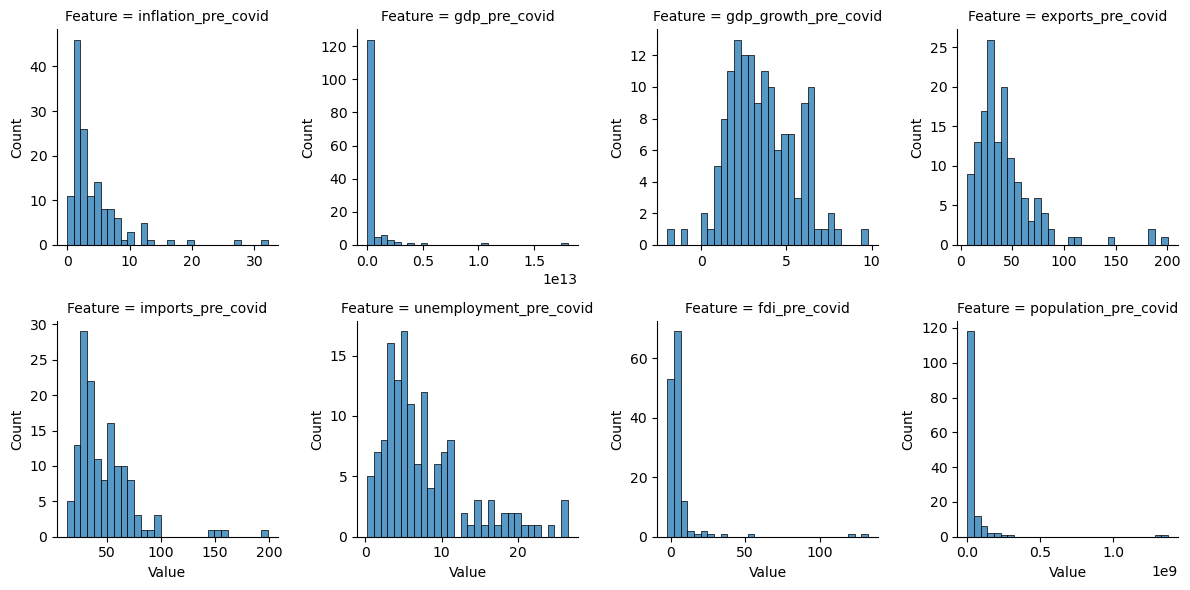

In [350]:
pre_hist_cols = ['inflation_pre_covid', 'gdp_pre_covid', 'gdp_growth_pre_covid',
            'exports_pre_covid', 'imports_pre_covid', 'unemployment_pre_covid',
            'fdi_pre_covid', 'population_pre_covid']

def gen_hists(data, cols):
    
    data_long = data[cols].melt(var_name="Feature", value_name="Value")
    
    hists = sns.FacetGrid(data_long, col="Feature", col_wrap=4, sharex=False, sharey=False, height=3)
    hists.map(sns.histplot, "Value", bins=30, edgecolor="black")
    plt.show()

gen_hists(country_data, pre_hist_cols)

In [356]:
key_features_post = ['inflation_post_covid', 'gdp_post_covid', 'gdp_growth_post_covid',
                'exports_post_covid', 'imports_post_covid', 'unemployment_post_covid', 'Total Cases',
                'Total Deaths', 'population_post_covid']

post_covid_headers = ["Inflation", "GDP", "GDP Growth", "Exports", "Imports", "Unemployment", 
                      "Total Covid Cases", "Total Covid Deaths", "Population"]

print("\nSUMMARY STATISTICS FOR GLOBAL ECONOMIC INDICATORS POST-COVID:\n")
gen_summ_table(country_data, key_features_post, post_covid_headers)


SUMMARY STATISTICS FOR GLOBAL ECONOMIC INDICATORS POST-COVID:

┌───────┬─────────────┬─────────────┬──────────────┬───────────┬───────────┬────────────────┬─────────────────────┬──────────────────────┬──────────────┐
│       │  Inflation  │     GDP     │  GDP Growth  │  Exports  │  Imports  │  Unemployment  │  Total Covid Cases  │  Total Covid Deaths  │  Population  │
├───────┼─────────────┼─────────────┼──────────────┼───────────┼───────────┼────────────────┼─────────────────────┼──────────────────────┼──────────────┤
│ count │     144     │     144     │     144      │    144    │    144    │      144       │         144         │         144          │     144      │
├───────┼─────────────┼─────────────┼──────────────┼───────────┼───────────┼────────────────┼─────────────────────┼──────────────────────┼──────────────┤
│ mean  │    10.61    │ 6.54057e+11 │     2.06     │   43.95   │   48.07   │      7.32      │     4.55051e+06     │       45393.4        │ 4.93233e+07  │
├───────┼───

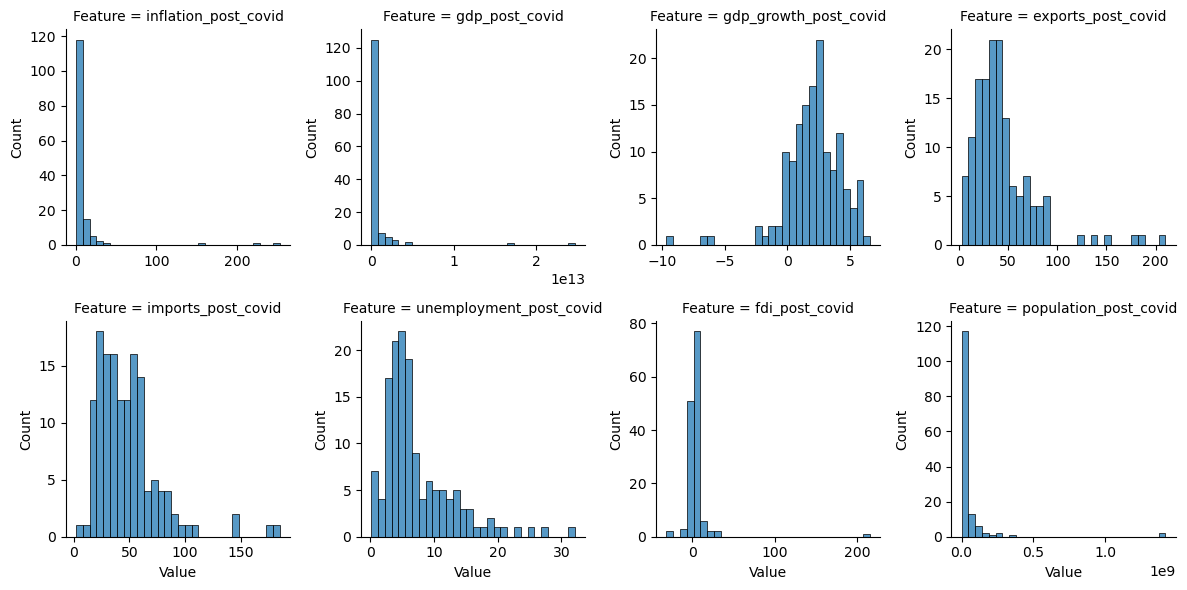

In [352]:
post_hist_cols = ['inflation_post_covid', 'gdp_post_covid', 'gdp_growth_post_covid',
            'exports_post_covid', 'imports_post_covid', 'unemployment_post_covid',
            'fdi_post_covid', 'population_post_covid']

gen_hists(country_data, post_hist_cols)

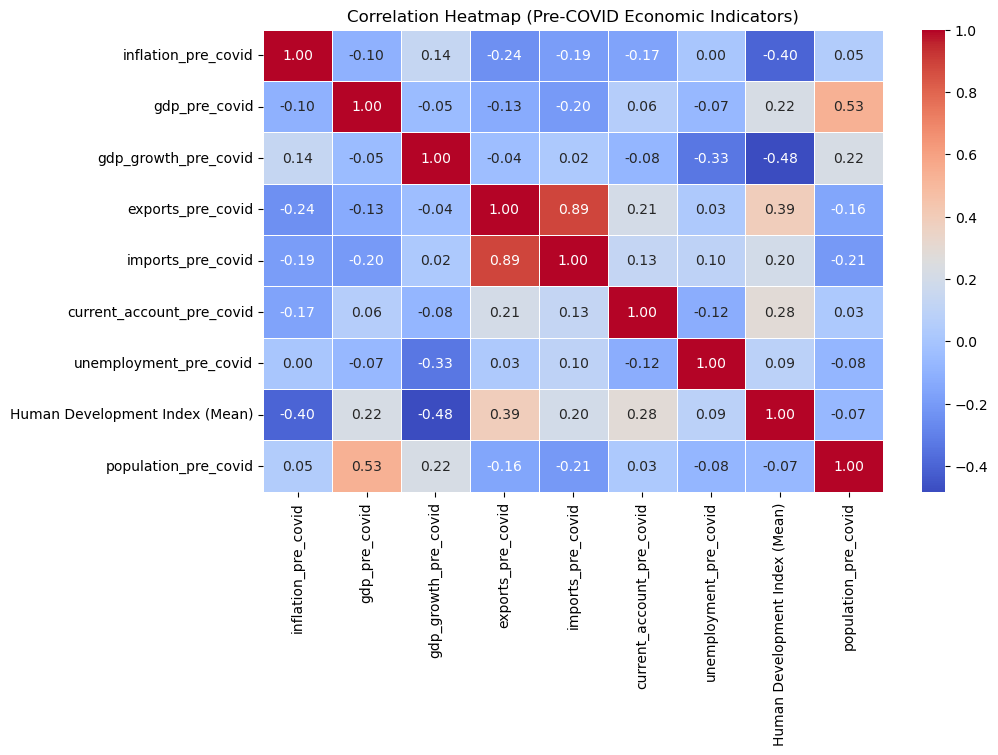

In [390]:
corr_features = ['inflation_pre_covid', 'gdp_pre_covid', 'gdp_growth_pre_covid',
                'exports_pre_covid', 'imports_pre_covid', 'current_account_pre_covid', 'unemployment_pre_covid',
                'Human Development Index (Mean)', 'population_pre_covid']

# Compute correlation matrix
corr_matrix = country_data[corr_features].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.title("Correlation Heatmap (Pre-COVID Economic Indicators)")
plt.show()

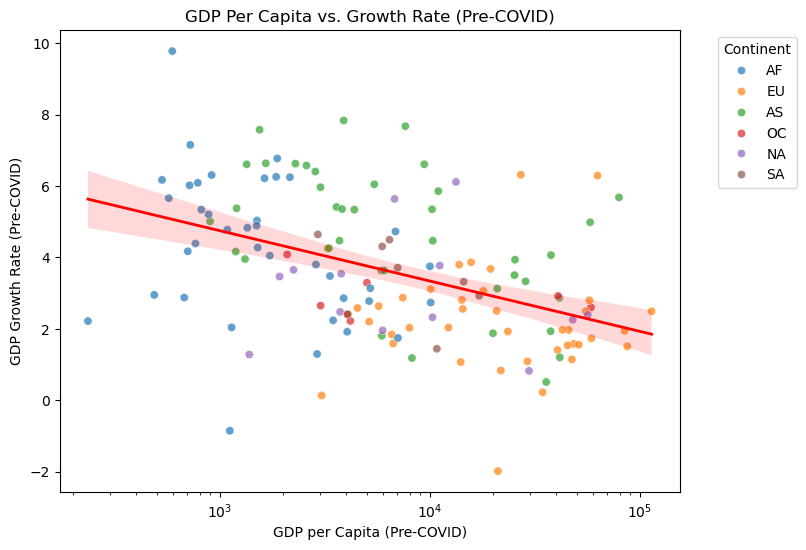

In [388]:
country_data["gdppercapita_pre_covid"] = country_data["gdp_pre_covid"] / country_data["population_pre_covid"]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=country_data, 
    x="gdppercapita_pre_covid", 
    y="gdp_growth_pre_covid", 
    hue="Continent",
    alpha=0.7  # Adjust transparency
)

# Add a regression line (without hue)
sns.regplot(
    data=country_data, 
    x="gdppercapita_pre_covid", 
    y="gdp_growth_pre_covid", 
    scatter=False,  # Only show the regression line
    logx=True,  # Log scale for GDP per capita
    line_kws={"color": "red", "linewidth": 2}  # Styling for regression line
)

# Log scale for x-axis
plt.xscale("log")

# Labels and title
plt.xlabel("GDP per Capita (Pre-COVID)")
plt.ylabel("GDP Growth Rate (Pre-COVID)")
plt.title("GDP Per Capita vs. Growth Rate (Pre-COVID)")

plt.legend(title = "Continent", bbox_to_anchor=(1.05, 1), loc="upper left")  

plt.show()

In [392]:
country_data.columns

Index(['Country Code', 'Country Name', 'inflation_pre_covid',
       'inflation_post_covid', 'gdp_pre_covid', 'gdp_post_covid',
       'gdp_growth_pre_covid', 'gdp_growth_post_covid', 'exports_pre_covid',
       'exports_post_covid', 'imports_pre_covid', 'imports_post_covid',
       'current_account_pre_covid', 'current_account_post_covid',
       'population_pre_covid', 'population_post_covid',
       'unemployment_pre_covid', 'unemployment_post_covid', 'fdi_pre_covid',
       'fdi_post_covid', 'Human Development Index (Mean)',
       'Life Expectancy at Birth (Mean)', 'Expected Years of Schooling (Mean)',
       'Total Cases', 'Total Deaths', 'Total Recovered', 'Active Cases',
       'Tot Cases/ 1M pop', 'Deaths/ 1M pop', 'Total Tests', 'Tests/ 1M pop',
       'Continent', 'gdppercapita_pre_covid'],
      dtype='object')

### **K-Means Clustering**

In [405]:
cluster_features = ['inflation_pre_covid', 'gdp_pre_covid', 'gdp_growth_pre_covid',
                'exports_pre_covid', 'imports_pre_covid', 'current_account_pre_covid', 'unemployment_pre_covid',
                'Human Development Index (Mean)', 'population_pre_covid', 'fdi_pre_covid',
                'Life Expectancy at Birth (Mean)', 'Expected Years of Schooling (Mean)']

pre_covid_data = country_data[cluster_features]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(pre_covid_data)

C:\Users\aymaa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\aymaa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\aymaa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\aymaa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

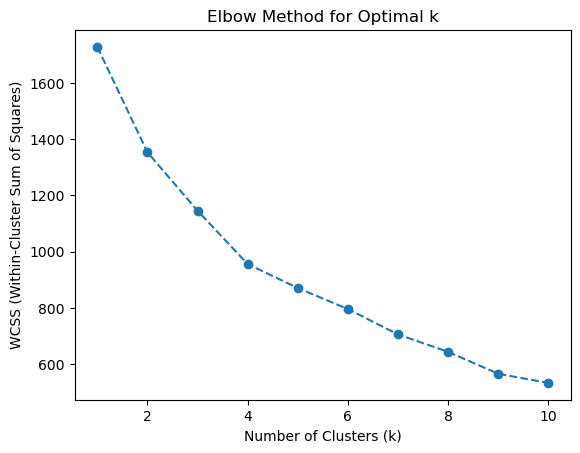

In [407]:
wcss = []  # Within-cluster sum of squares

for k in range(1, 11):  # Try k from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=100, n_init=10)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)  # Inertia = sum of squared distances to closest centroid

# Plot the Elbow Curve
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.show()

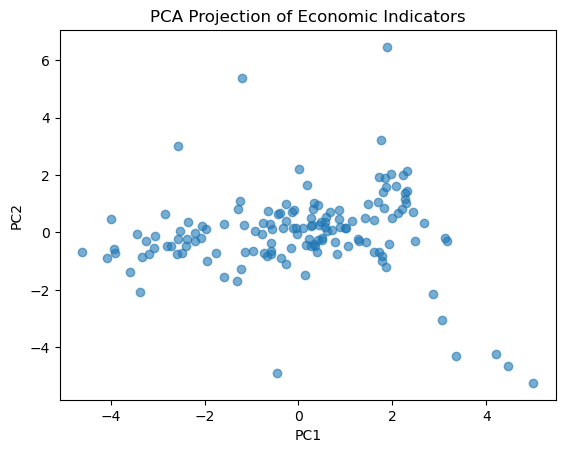

In [409]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

plt.scatter(pca_data[:, 0], pca_data[:, 1], alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection of Economic Indicators")
plt.show()

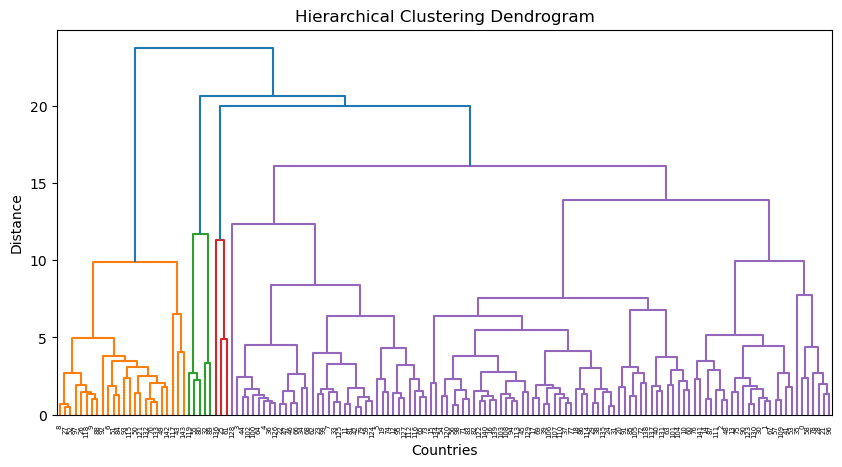

In [411]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(scaled_data, method='ward')

plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Countries")
plt.ylabel("Distance")
plt.show()

In [425]:
from scipy.cluster.hierarchy import fcluster

# Generate cluster labels at height 15
cluster_labels = fcluster(linkage_matrix, t=10, criterion='distance')

# Count the unique clusters
num_clusters = len(set(cluster_labels))
print(f"Number of clusters at height 15: {num_clusters}")

Number of clusters at height 15: 9


C:\Users\aymaa\AppData\Local\Temp\ipykernel_18996\1619452488.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_covid_data["Cluster"] = labels


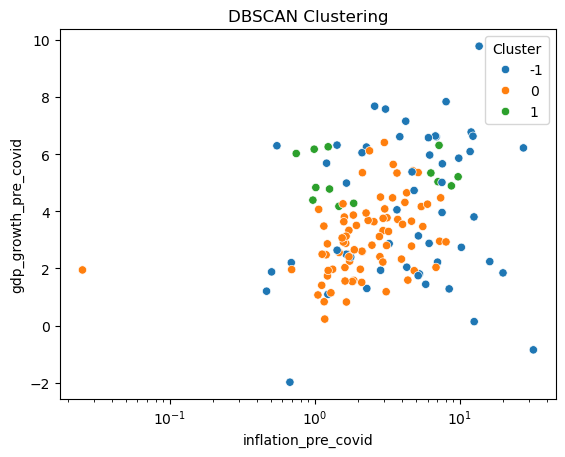

In [419]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.5, min_samples=5)  # Adjust parameters
labels = dbscan.fit_predict(scaled_data)

pre_covid_data["Cluster"] = labels
sns.scatterplot(data=pre_covid_data, x="inflation_pre_covid", y="gdp_growth_pre_covid", hue="Cluster", palette="tab10")
plt.xscale("log")
plt.title("DBSCAN Clustering")
plt.show()